In [280]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from JSAnimation import IPython_display
from matplotlib import animation

Populating the interactive namespace from numpy and matplotlib


SIMULACIÓN

Se utilizo las MISMAS CLASES que en el modelo original

In [313]:
class Planeta:
    step=0
    area_blanca = []
    area_negra =[]
    
    def __init__(self,plantas, albedo_f, luminosidad, prop_fertil = 0.98, q = 15, boltz = 5.67e-8):
        self.blanca = plantas[0]
        self.negra = plantas[1]       
        self.albedo_f = albedo_f
        self.luminosidad = luminosidad
        self.boltz = boltz
        self.albedo_p = None
        self.temp_g = None
        self.q = q
        self.prop_fertil = prop_fertil
        self.step = 0
        
    def actualiza_temp_g(self):
        self.temp_g = ((self.luminosidad[self.step]/(self.boltz))*(1 - self.albedo_p))**0.25 
        #print self.temp_g
    
    def actualiza_albedo_p(self):
        self.prop_fertil = 1 - self.blanca.prop_area - self.negra.prop_area
        self.albedo_p = self.blanca.prop_area * self.blanca.albedo + self.negra.prop_area * self.negra.albedo + self.prop_fertil * self.albedo_f
        #print self.albedo_p
        
    def vivir(self):
        for i in self.luminosidad:
            self.actualiza_albedo_p()
            self.actualiza_temp_g()
            self.blanca.actualizar(self)
            self.negra.actualizar(self)
            self.area_blanca.append(self.blanca.prop_area)
            self.area_negra.append(self.negra.prop_area)
            self.step += 1
        
        
    def iam(self):
        print "TEMPERATUA GLOBAL: " + str(self.temp_g) + " ALBEDO GLOBAL: " + str(self.albedo_p)
        print "PROPORCION FERTIL: " + str(self.prop_fertil)
        print "STEP " + str(self.step)
        print "AREA NEGRAS " + str(len(self.area_negra))
        for i in self.area_negra:
            print i
        print "AREAS BLANCAS:" + str(len(self.area_blanca))
        for i in self.area_blanca:
            print i
        
        
    def grafica(self):
        plt.plot(self.luminosidad,self.area_blanca)
        plt.plot(self.luminosidad,self.area_negra)
        
    
    def convertir(self):
        #Discretizo cada uno de mis vectores de areas, de tal manera que 
        #por cada intervalo de tiempo(lugar en mi arreglo), tengo un tercia de números que contienen
        # el número de margaritas  que existen por color
        self.area_blanca= np.array(self.area_blanca)*100                        
        self.area_blanca = np.round(self.area_blanca).astype(int)
        self.area_negra= np.array(self.area_negra)*100
        self.area_negra = np.round(self.area_negra).astype(int)
        self.area_fertil = np.ones(100)*100 - self.area_blanca - self.area_negra
        self.area_fertil = self.area_fertil.astype(int)
    
    def simular(self):
        self.convertir()
        agentes=[]
        agentes.append(Agente(tipo=0,locacion = (0.5, 0.5)))
        agentes.append(Agente(tipo=1,locacion= (0.5, 1.5)))
        lista = [(i+.5,j+.5) for i in range(0,10)for j in range(0,10)][2:]
        agentes.extend(Agente(tipo=2,locacion= lista[i]) for i in range(len(lista)))
        sim = Mundo2(agentes = agentes,ar_negra = self.area_negra,ar_blanca=self.area_blanca,ar_fertil=self.area_fertil, steps = 100,metodo = 1)
        sim.simular()
    

In [314]:
class Planta:
    dif_area =0
    temp_l=0
    tasa_cre = 0
    def __init__(self,color, albedo, prop_area = 0.01, tasa_muerte = 0.1
               ,superior = 313, inferior = 278):
        self.color = color
        self.albedo = albedo
        self.prop_area = prop_area
        self.tasa_muerte = tasa_muerte
        self.superior = superior
        self.inferior = inferior
        

        
    def actualiza_temp_l(self, mundo):
        self.temp_l = mundo.q * (mundo.albedo_p - self.albedo) + mundo.temp_g
        #print self.color + " : " + str(self.temp_l)
        
    def actualiza_taza_cre(self):
        if self.temp_l > self.inferior and self.temp_l < self.superior :
            self.tasa_cre = (self.temp_l - self.inferior) * (self.superior - self.temp_l) * 4 / (self.inferior -self.superior)**2
            #print "TASA DE CRECIMIENTO "+ str(self.tasa_cre)
        else:
            self.tasa_cre = 0
                
            
    def actualiza_area(self,mundo):
        self.dif_area = self.prop_area*(self.tasa_cre * mundo.prop_fertil - self.tasa_muerte)
        #print "El difrencial de area" + str(self.dif_area)
        self.prop_area = self.prop_area  + self.dif_area
        if self.prop_area <= 0.01:
            self.prop_area = 0.01
        if self.prop_area >= .99:
            self.prop_area = .99

    def actualizar(self,mundo):
        self.actualiza_temp_l(mundo)
        self.actualiza_taza_cre()
        self.actualiza_area(mundo)
    
    def iam(self):
        print "COLOR: " + self.color + " ALBEDO: " + str(self.albedo)
        print "TASA DE MUERTE: " + str(self.tasa_muerte) + " TASA DE CRECIMIENTO: " + str(self.tasa_cre)
        print "TEMPERATURA LOCAL:" + str(self.temp_l) 
        print "AREA " + str(self.prop_area)

        

In [315]:
class Mundo2:
    def __init__(self, agentes,ar_negra,ar_blanca,ar_fertil, ancho=15, alto=15, steps=100,metodo=0):
        self.agentes = agentes
        self.ancho = ancho
        self.alto = alto
        self.steps = steps
        self.ar_negra = ar_negra
        self.ar_blanca = ar_blanca
        self.ar_fertil = ar_fertil
        self.metodo = metodo
        self.init_anim()
            
    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
        self.ax.set_axis_bgcolor('azure')
        plot_args = {'markersize' : 8, 'alpha' : 1}
        self.puntos_0, = self.ax.plot([], [], 'o', markerfacecolor='white', **plot_args)
        self.puntos_1, = self.ax.plot([], [], 'o', markerfacecolor='black', **plot_args)
        self.puntos_2, = self.ax.plot([], [], 'o', markerfacecolor='red', **plot_args)
        
        
    def dibujar(self, step):
        x_values_0, y_values_0 = [], []
        x_values_1, y_values_1 = [], []
        x_values_2, y_values_2 = [], []
        for agente in self.agentes:
            x, y = agente.locacion
            if agente.tipo == 0:
                x_values_0.append(x)
                y_values_0.append(y)
                
            if agente.tipo == 1:
                    x_values_1.append(x)
                    y_values_1.append(y)
            if agente.tipo == 2:
                    x_values_2.append(x)
                    y_values_2.append(y)        
        print x_values_1, y_values_1
        self.puntos_0.set_data(x_values_1, y_values_1)
        self.puntos_1.set_data(x_values_0, y_values_0)
        self.puntos_2.set_data(x_values_2, y_values_2)
       
        self.ax.set_title('Tiempo {}'.format(step))
        
        return 
       
    def actualizar(self, step):   
        self.dibujar(step) # Dibuja el mundo 
        if self.metodo==0:
            pos = self.obtener_posiciones(self.ar_negra,self.ar_blanca,self.ar_fertil,step)
        else:
            pos = self.obtener_posiciones_2(self.ar_negra,self.ar_blanca,self.ar_fertil,step)
        for i in range(len(pos[0])):
            self.agentes[i].actualizar(0,pos[0][i])
        for i in range(len(pos[1])):
            self.agentes[i+len(pos[0])].actualizar(1,pos[1][i])
        for i in range(len(pos[2])):
            self.agentes[i+len(pos[0])+len(pos[1])].actualizar(2,pos[2][i])
       
    
    def clean_screen(self):
        self.puntos_0.set_data([], [])
        self.puntos_1.set_data([], [])
        self.puntos_2.set_data([], [])
        return 
    
    def obtener_posiciones(self,area_negra,area_blanca,area_fertil,step):
        negras = area_negra[step]
        blancas = area_blanca[step]
        fertil = 100-negras-blancas
        posiciones = [(i+.5,j+.5) for i in range(0,10)for j in range(0,10)]
        po_neg=[]
        for i in  range(negras): 
            n = np.random.choice(100-i)
            po_neg.append(posiciones.pop(n))  
        po_blan = []
        k = 100-negras
        for i in  range(blancas):
            n = np.random.choice(k-i)
            po_blan.append(posiciones.pop(n))
        return po_neg,po_blan,posiciones
    
    def obtener_posiciones_2(self,area_negra,area_blanca,area_fertil,step):
        negras = area_negra[step]
        blancas = area_blanca[step]
        fertil = 100-negras-blancas
        posiciones = [(i+.5,j+.5) for i in range(0,10)for j in range(0,10)]
        po_neg=[]
        for i in  range(negras): 
            po_neg.append(posiciones[i])  
        po_blan = []
        for i in  range(blancas):
            po_blan.append(posiciones[i+negras])
            
        posiciones = posiciones[negras+blancas:]
        return po_neg,po_blan,posiciones

          
    def simular(self):
        anim = animation.FuncAnimation(self.fig, self.actualizar, init_func=self.clean_screen , frames=self.steps, interval=1000, blit=True)
        return anim

In [316]:
class Agente:
    """ Agente general """
    def __init__(self, tipo, locacion):
        self.tipo = tipo
        self.locacion = np.array(locacion)
     
    def actualizar(self, tipo,locacion):
        self.tipo = tipo
        self.locacion = np.array(locacion)

In [317]:
def condiciones_iniciales():
    negra = Planta("negra",.25)
    blanca = Planta("blanca",.75)
    luminosidad = np.linspace(.6,1.8,100)
    luminosidad *=1000
    plantas = [negra,blanca]
    primer_intento = Planeta(plantas, 0.5,luminosidad)
    primer_intento.vivir()
    primer_intento.simular()
    

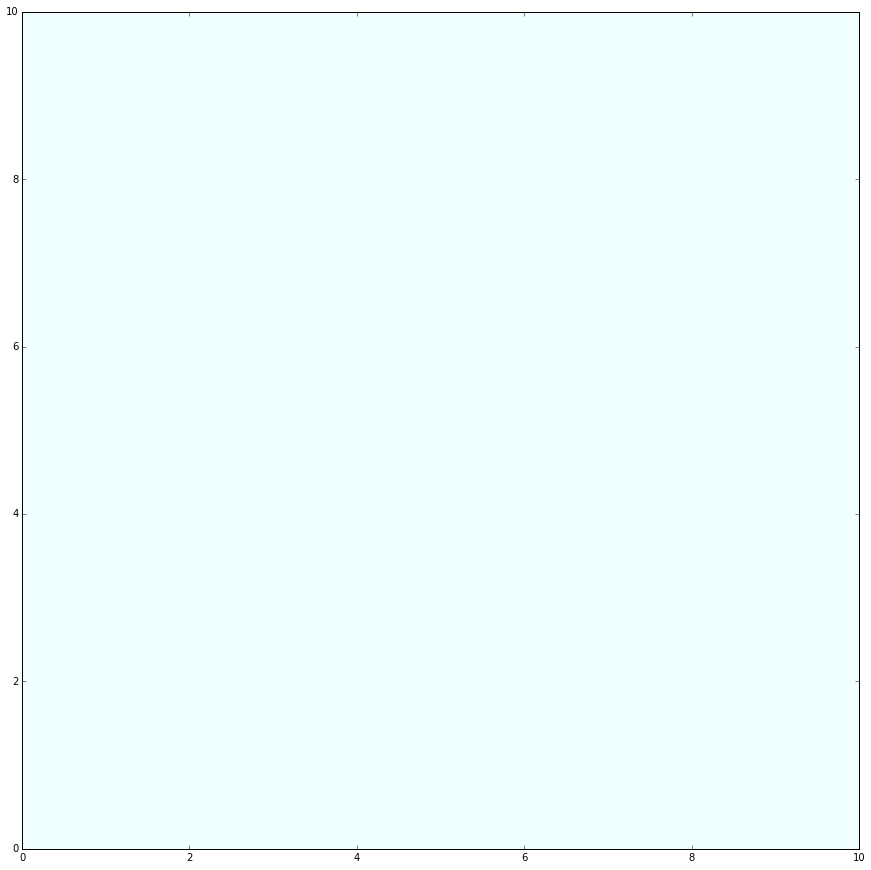

In [318]:
condiciones_iniciales()